<a href="https://colab.research.google.com/github/olsenme/MLIntro/blob/master/Classification_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will build a classification model using Naive Bayes classifier from python's scikit learn library

## Table of contents
1. Data Loading
2. Data Exploration
3. Visualization
4. Preprocessing
5. Bernoulli Naive Bayes model and its variants
6. Gaussian Naive Bayes
7. Ensemble of Bernoulli and Gaussian model
8. Model comparision using ROC curve

## Loading Data

In this section we will import all the necessary packages and load the datasets we plan to work on. We will use the 
<a href='https://www.kaggle.com/jessemostipak/hotel-booking-demand'> Hotel booking data </a> and build a model to determine which customers will cancel their hotel booking

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,auc,roc_auc_score,roc_curve
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Load the data
# file_path = 'C:\Users\Tejal\Documents\Tejal\WWC-siliconvalley\hotel_bookings.csv'
file_path = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv'
df = pd.read_csv(file_path)

## Explore the dataset

Understanding the data, its features and distribution is a major part of builiding ML models. 

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# Data has 119390 rows (data points) and 32 columns (features)
df.shape   

(119390, 32)

In [5]:
# Check the datatype of features
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [6]:
# Feature list 
df.columns

Index([u'hotel', u'is_canceled', u'lead_time', u'arrival_date_year',
       u'arrival_date_month', u'arrival_date_week_number',
       u'arrival_date_day_of_month', u'stays_in_weekend_nights',
       u'stays_in_week_nights', u'adults', u'children', u'babies', u'meal',
       u'country', u'market_segment', u'distribution_channel',
       u'is_repeated_guest', u'previous_cancellations',
       u'previous_bookings_not_canceled', u'reserved_room_type',
       u'assigned_room_type', u'booking_changes', u'deposit_type', u'agent',
       u'company', u'days_in_waiting_list', u'customer_type', u'adr',
       u'required_car_parking_spaces', u'total_of_special_requests',
       u'reservation_status', u'reservation_status_date'],
      dtype='object')

In [7]:
# Check for null values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False,inplace=True)
missing_value_df

,column_name,percent_missing
company,company,94.306893
agent,agent,13.686238
country,country,0.408744
children,children,0.003350
reserved_room_type,reserved_room_type,0.000000
assigned_room_type,assigned_room_type,0.000000
booking_changes,booking_changes,0.000000
deposit_type,deposit_type,0.000000
hotel,hotel,0.000000
previous_cancellations,previous_cancellations,0.000000


Company, agent, country and children have null values. There are multiple techniques for imputing null value but for simplicity we impute them with 0. As company has a very high null value percentage we will drop the column

In [0]:
# Let us create a copy of dataframe for backup and impute null with 0
backup_df=df.copy
df = df.drop('company',axis=1)
df=df.fillna(0)

In [0]:
# The df has no Null values
(df['agent'].isnull().sum()/len(df)) * 100

0

## Data Visualization

In this task, our target variable is is_cancelled which indicates if the booking was cancelled. 1 --> canceled, 0 --> Not canceled 

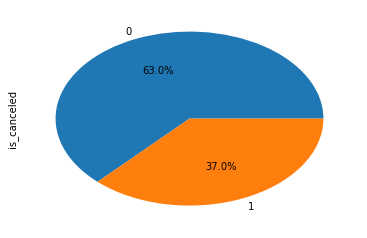

In [9]:
df['is_canceled'].value_counts().plot(kind='pie',autopct='%1.1f%%')

37% customers have cancelled their bookings. we see that our data in imbalanced

In [10]:
df.columns

Index([u'hotel', u'is_canceled', u'lead_time', u'arrival_date_year',
       u'arrival_date_month', u'arrival_date_week_number',
       u'arrival_date_day_of_month', u'stays_in_weekend_nights',
       u'stays_in_week_nights', u'adults', u'children', u'babies', u'meal',
       u'country', u'market_segment', u'distribution_channel',
       u'is_repeated_guest', u'previous_cancellations',
       u'previous_bookings_not_canceled', u'reserved_room_type',
       u'assigned_room_type', u'booking_changes', u'deposit_type', u'agent',
       u'days_in_waiting_list', u'customer_type', u'adr',
       u'required_car_parking_spaces', u'total_of_special_requests',
       u'reservation_status', u'reservation_status_date'],
      dtype='object')

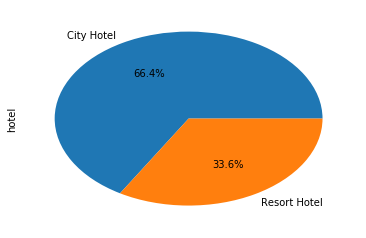

In [11]:
# Hotel feature count and distribution across 0 and 1 class 
df['hotel'].value_counts().plot(kind='pie',autopct='%1.1f%%')

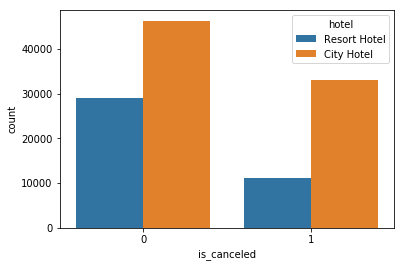

In [12]:
sns.countplot(x='is_canceled',hue='hotel',data=df)

As data has higher city hotel reservation data points compared to resort, above observation is on par with  same trend

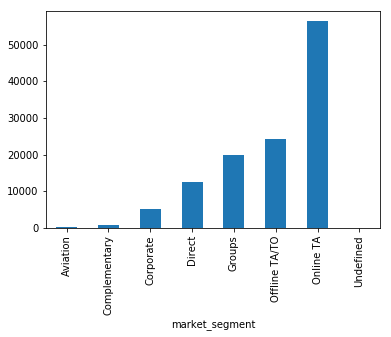

In [13]:
#market segments
df.groupby(['market_segment'])['is_canceled'].count().plot(kind='bar')

## Feature Engineering

1. Derive new features using existing features
2. Remove irrelevant features
3. Transform existing features
4. Encoding categorical variables

In [0]:
# Split data into train test set in train:test=70:30 size
train, test = train_test_split(df, test_size=0.3, random_state = 42)

In [15]:
train.shape

(83573, 31)

In [16]:
test.shape

(35817, 31)

In [0]:
#Let us add weekend stay and weekday stay days to get total days of stay
train['total_days'] = train['stays_in_week_nights'] + train['stays_in_weekend_nights']
test['total_days'] = test['stays_in_week_nights'] + test['stays_in_weekend_nights']

# drop the weekend stay and weekday stay days features
train = train.drop('stays_in_week_nights',axis=1).drop('stays_in_weekend_nights',axis=1)
test = test.drop('stays_in_week_nights',axis=1).drop('stays_in_weekend_nights',axis=1)

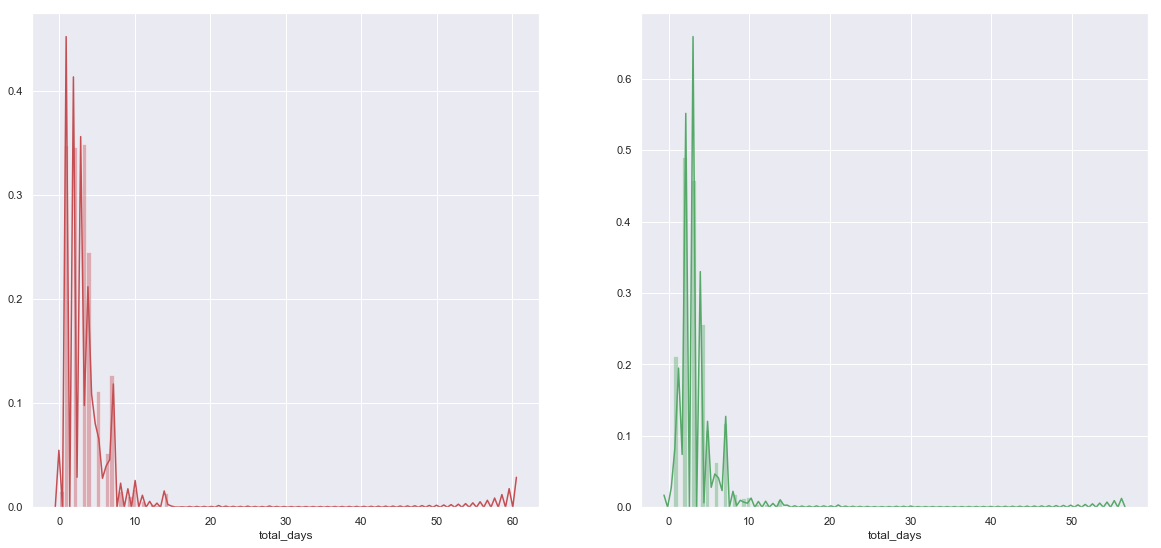

In [0]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
sns.set(rc={"figure.figsize": (20, 20)})
subplot(2,2,1)
ax = sns.distplot(train_0['total_days'], bins=100, color='r')
subplot(2,2,2)
ax=sns.distplot(train_1['total_days'], bins=100, color='g')

In [0]:
#Total customers
train['total_customers'] = train['adults'] + train['children']+train['babies']
test['total_customers'] = test['adults'] + test['children']+test['babies']

train = train.drop('adults',axis=1).drop('children',axis=1).drop('babies',axis=1)
test = test.drop('adults',axis=1).drop('children',axis=1).drop('babies',axis=1)

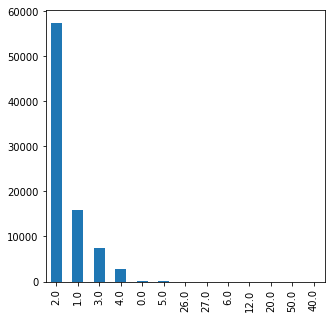

In [21]:
train['total_customers'].value_counts().plot('bar',figsize=(5,5)) 

In [22]:
train = train.drop(['reservation_status_date'],axis=1)
test = test.drop(['reservation_status_date'],axis=1)

KeyError: ignored

In [23]:
print (len(train['agent'].unique())) # 314 unique values - Large number of unique agents and it is categorical, difficult to encode
train = train.drop('agent',axis=1)
test = test.drop('agent',axis=1)

314


In [24]:
print(len(train['country'].unique())) # 170 countries
train = train.drop('country',axis=1)
test = test.drop('country',axis=1)

170


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0d3b51250>]],
      dtype=object)

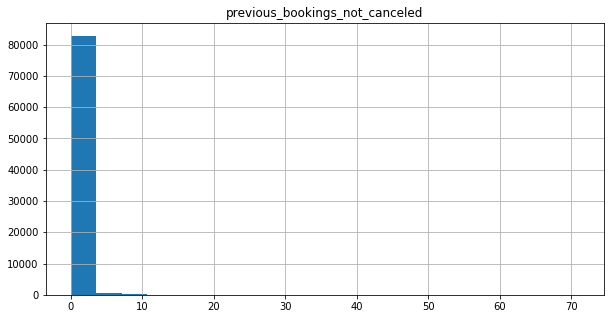

In [25]:
train.hist(column='previous_bookings_not_canceled',bins=20,figsize=(10,5))

In [0]:
#train['previous_bookings_not_canceled'].value_counts() # We observe that most data has value = 0; hence we drop the feature
#train.groupby(['is_canceled'])['previous_bookings_not_canceled'].value_counts() # We observe that data distribution across both class is remains same
train = train.drop('previous_bookings_not_canceled',axis=1)
test = test.drop('previous_bookings_not_canceled',axis=1)

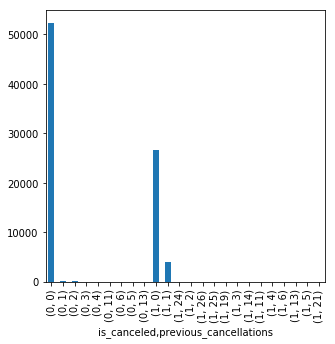

In [27]:
train.groupby(['is_canceled'])['previous_cancellations'].value_counts().plot('bar',figsize=(5,5))
# We observe that most data has value = 0; and trend remains same across the 2 classes
train = train.drop('previous_cancellations',axis=1)
test = test.drop('previous_cancellations',axis=1)

In [28]:
len(train.columns)

23

In [0]:
backup_train = train.copy()
backup_test = test.copy()

## Feature Correlation 
We will convert categorical features to numeric values using Label Encoder

In [0]:
#Custom encoding
train['arrival_date_month'] = train['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, \
                                                         'April':4, 'May':5, 'June':6, 'July':7,\
                                                         'August':8, 'September':9, 'October':10, \
                                                         'November':11, 'December':12})
test['arrival_date_month'] = test['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, \
                                                         'April':4, 'May':5, 'June':6, 'July':7,\
                                                         'August':8, 'September':9, 'October':10, \
                                                         'November':11, 'December':12})

In [0]:
encode = LabelEncoder()

In [32]:
train.columns

Index([u'hotel', u'is_canceled', u'lead_time', u'arrival_date_year',
       u'arrival_date_month', u'arrival_date_week_number',
       u'arrival_date_day_of_month', u'meal', u'market_segment',
       u'distribution_channel', u'is_repeated_guest', u'reserved_room_type',
       u'assigned_room_type', u'booking_changes', u'deposit_type',
       u'days_in_waiting_list', u'customer_type', u'adr',
       u'required_car_parking_spaces', u'total_of_special_requests',
       u'reservation_status', u'total_days', u'total_customers'],
      dtype='object')

In [33]:
train['arrival_date_year'].unique()

array([2016, 2015, 2017])

In [0]:
cat_col=['hotel','arrival_date_year','meal','market_segment','distribution_channel','reserved_room_type', 'assigned_room_type',\
        'deposit_type','customer_type','reservation_status']
for i in cat_col:
    train[i] = encode.fit_transform(train[i])

In [37]:
train[cat_col].head()

,hotel,arrival_date_year,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
9710,1,1,0,6,3,3,3,0,2,0
40307,0,0,0,4,3,0,0,0,3,0
110051,0,2,0,6,3,3,3,0,2,1
22999,1,2,0,6,3,0,0,0,2,1
8344,1,1,0,6,3,0,0,0,2,0


In [36]:
train['arrival_date_year'].unique()

array([1, 0, 2])

### Feature correlation
<b>Spearman</b> and <b>Pearson</b> are the 2 statistical methods to compute the correlation between features. 
- Pearson is suggested method for features with continuous values and linear relationship
- Spearman is suggested method when features have ordinal categorical data or non-linear relationship
<br>Pandas correlation method by default uses Pearson method, but we can also change it to spearman </br>

In [39]:
train.corr()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,meal,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,total_days,total_customers
hotel,1.000000,-0.135266,-0.075241,-0.035946,-0.005091,-0.004423,0.002416,-0.009009,-0.084364,-0.174473,0.051430,0.246741,0.305863,0.070201,-0.155026,-0.071502,-0.047622,-0.099411,0.216490,0.042221,0.123520,0.242948,0.040640
is_canceled,-0.135266,1.000000,0.293248,0.017205,0.009405,0.006479,-0.006537,-0.014264,0.057241,0.166512,-0.085456,-0.059555,-0.173898,-0.140347,0.467354,0.054322,-0.065687,0.047221,-0.194711,-0.237031,-0.915883,0.021257,0.048319
lead_time,-0.075241,0.293248,1.000000,0.038852,0.130725,0.126104,0.002054,0.004313,0.013143,0.220976,-0.123915,-0.107382,-0.173158,0.004114,0.375777,0.170237,0.075026,-0.061618,-0.116425,-0.095988,-0.302591,0.157373,0.073295
arrival_date_year,-0.035946,0.017205,0.038852,1.000000,-0.528170,-0.540726,0.004283,0.067755,0.111935,0.025582,0.007080,0.091785,0.035793,0.030485,-0.065299,-0.057384,-0.005010,0.193542,-0.017678,0.111282,-0.017228,0.030954,0.050789
arrival_date_month,-0.005091,0.009405,0.130725,-0.528170,1.000000,0.995092,-0.028815,-0.012907,0.001094,0.007844,-0.029571,-0.010345,-0.008577,0.003804,0.002369,0.020000,-0.030016,0.080533,0.001262,0.028146,-0.020803,0.019015,0.027894
arrival_date_week_number,-0.004423,0.006479,0.126104,-0.540726,0.995092,1.000000,0.064206,-0.015267,-0.000917,0.005999,-0.029043,-0.010504,-0.007890,0.004611,0.002251,0.023749,-0.028746,0.077035,0.003264,0.026228,-0.016978,0.016210,0.025711
arrival_date_day_of_month,0.002416,-0.006537,0.002054,0.004283,-0.028815,0.064206,1.000000,-0.007447,-0.004199,0.001474,-0.007002,0.016134,0.012058,0.012223,-0.001229,0.021440,0.011833,0.028831,0.010960,0.003720,0.012448,-0.027971,0.005131
meal,-0.009009,-0.014264,0.004313,0.067755,-0.012907,-0.015267,-0.007447,1.000000,0.146540,0.117985,-0.055888,-0.121964,-0.121648,0.019315,-0.090271,-0.007020,0.046316,0.056627,-0.039101,0.024430,0.011251,0.044204,-0.007995
market_segment,-0.084364,0.057241,0.013143,0.111935,0.001094,-0.000917,-0.004199,0.146540,1.000000,0.767718,-0.246093,0.093214,0.024110,-0.072903,-0.184932,-0.043077,-0.166540,0.231270,-0.061893,0.273916,-0.059299,0.126700,0.212585
distribution_channel,-0.174473,0.166512,0.220976,0.025582,0.007844,0.005999,0.001474,0.117985,0.767718,1.000000,-0.258141,-0.042541,-0.105705,-0.114324,0.091225,0.048186,-0.068619,0.093562,-0.132287,0.098250,-0.169993,0.100968,0.144714


In [40]:
feat_corr = train.corr()
feat_corr['deposit_type'].sort_values()

reservation_status            -0.464571
total_of_special_requests     -0.266183
assigned_room_type            -0.240921
reserved_room_type            -0.198719
market_segment                -0.184932
hotel                         -0.155026
booking_changes               -0.110863
total_days                    -0.100240
meal                          -0.090271
required_car_parking_spaces   -0.089800
adr                           -0.086046
total_customers               -0.078236
customer_type                 -0.072593
arrival_date_year             -0.065299
is_repeated_guest             -0.057747
arrival_date_day_of_month     -0.001229
arrival_date_week_number       0.002251
arrival_date_month             0.002369
distribution_channel           0.091225
days_in_waiting_list           0.121999
lead_time                      0.375777
is_canceled                    0.467354
deposit_type                   1.000000
Name: deposit_type, dtype: float64

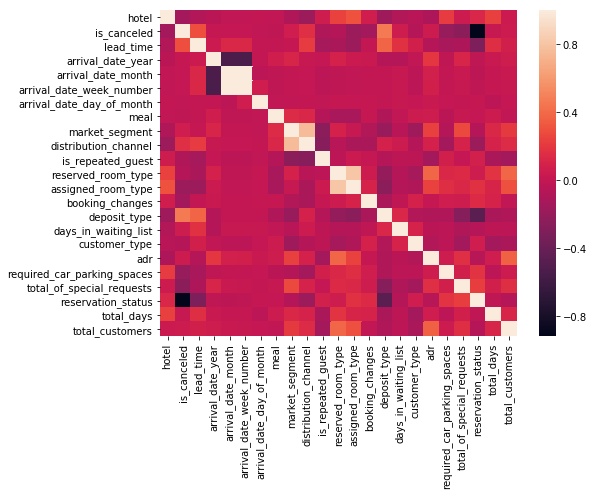

In [41]:
plt.figure(figsize=(8,6))
sns.heatmap(feat_corr)

The diagonal shows correlation of each feature with itself, hence indicates highest correlation.
Using the table and plot we observe that few features have veryhigh correlation
Ex:- 
1. Arrival_date_year and arrival_date_month = -0.52
2. Reservation_status and deposit type = -0.46 
3. market_segment vs distribution_channel = 0.76
4. reserved_room_type vs assigned_room_type = 0.81

It is advisable to remove one of the features from the high correlation pair, but we will retain them and see the effect on performance

In [42]:
feat_corr['is_canceled'].sort_values()

reservation_status            -0.915883
total_of_special_requests     -0.237031
required_car_parking_spaces   -0.194711
assigned_room_type            -0.173898
booking_changes               -0.140347
hotel                         -0.135266
is_repeated_guest             -0.085456
customer_type                 -0.065687
reserved_room_type            -0.059555
meal                          -0.014264
arrival_date_day_of_month     -0.006537
arrival_date_week_number       0.006479
arrival_date_month             0.009405
arrival_date_year              0.017205
total_days                     0.021257
adr                            0.047221
total_customers                0.048319
days_in_waiting_list           0.054322
market_segment                 0.057241
distribution_channel           0.166512
lead_time                      0.293248
deposit_type                   0.467354
is_canceled                    1.000000
Name: is_canceled, dtype: float64

The reservation_status has high correlation with is_canceled. For iteration 1, lets retain the feature.

## Implementing Bernoulli NB

Bernoulli NB classifier works on discrete data with Binary or boolean features. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB">sklearn documentation</a>

### Data discretization
Convert continuous features to categorical features

In [0]:
train = backup_train.copy()
test=backup_test.copy()

In [44]:
train.select_dtypes(include=[np.number]).dtypes

is_canceled                      int64
lead_time                        int64
arrival_date_year                int64
arrival_date_week_number         int64
arrival_date_day_of_month        int64
is_repeated_guest                int64
booking_changes                  int64
days_in_waiting_list             int64
adr                            float64
required_car_parking_spaces      int64
total_of_special_requests        int64
total_days                       int64
total_customers                float64
dtype: object

### We will discretize the following continuous features -
1. lead_time - Use quantile 
2. arrival_date_week_number - Use Custom bin size
3. days_in_waiting_list - Drop the column
4. adr - Use Quantile
5. required_car_parking_spaces - 0 or more
6. total_of_special_requests - Cap the feature to 3 requests        
7. total_customers - Cap the feature to 4 customers               
8. total_days - Use quantile

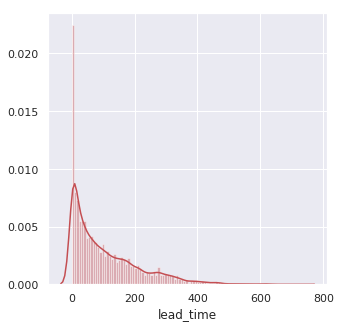

In [45]:
sns.set(rc={"figure.figsize": (5, 5)})
ax = sns.distplot(train['lead_time'], bins=100, color='r')

In [0]:
train['lead_time_q'], bins = pd.qcut(train['lead_time'], q=4,labels=False, retbins=True)
train=train.drop('lead_time',axis=1)
test['lead_time_q']=pd.cut(test['lead_time'], bins=bins,labels=False,precision=0)
test=test.drop('lead_time',axis=1)

In [47]:
train[['lead_time_q']][:5]

,lead_time_q
9710,2
40307,1
110051,2
22999,0
8344,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0d33fa310>],
      dtype=object)

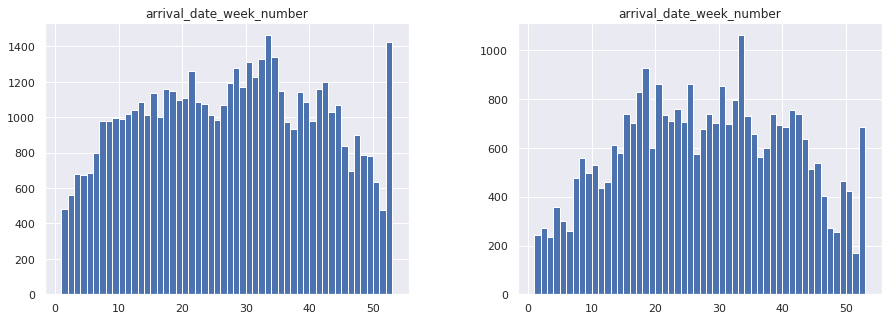

In [48]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train_0.hist(column='arrival_date_week_number',bins=52,ax=axes[0])
train_1.hist(column='arrival_date_week_number',bins=52,ax=axes[1])

In [0]:
bins = [1,13,26,39,53]
train['arrival_date_week_number_q'] = pd.cut(train['arrival_date_week_number'], bins=bins,labels=False)
train=train.drop('arrival_date_week_number',axis=1)
test['arrival_date_week_number_q']=pd.cut(test['arrival_date_week_number'], bins=bins,labels=False)
test=test.drop('arrival_date_week_number',axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0d31f58d0>],
      dtype=object)

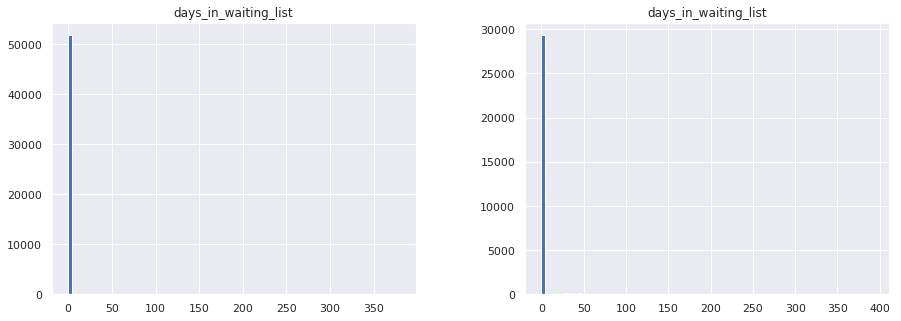

In [50]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train_0.hist(column='days_in_waiting_list',bins=100,ax=axes[0])
train_1.hist(column='days_in_waiting_list',bins=100,ax=axes[1])

In [0]:
train=train.drop('days_in_waiting_list',axis=1)
test=test.drop('days_in_waiting_list',axis=1)

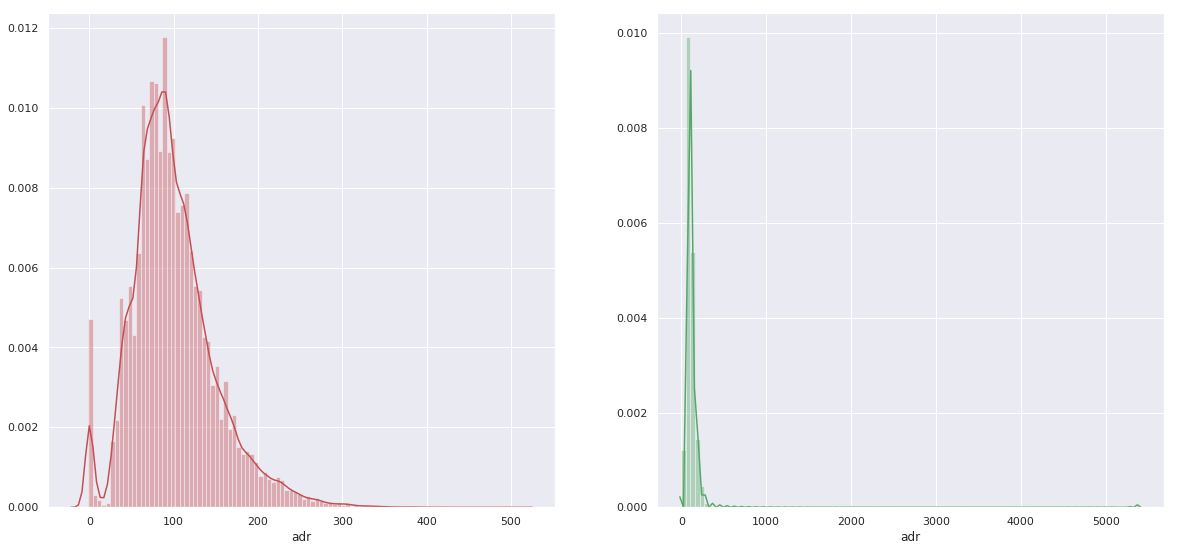

In [52]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
sns.set(rc={"figure.figsize": (20, 20)})
subplot(2,2,1)
ax = sns.distplot(train_0['adr'], bins=100, color='r')
subplot(2,2,2)
ax=sns.distplot(train_1['adr'], bins=100, color='g')

In [0]:
train['adr_q'], bins = pd.qcut(train['adr'], q=4,labels=False, retbins=True)
train=train.drop('adr',axis=1)
test['adr_q']=pd.cut(test['adr'], bins=bins,labels=False,precision=0)
test=test.drop('adr',axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0d2cb7190>],
      dtype=object)

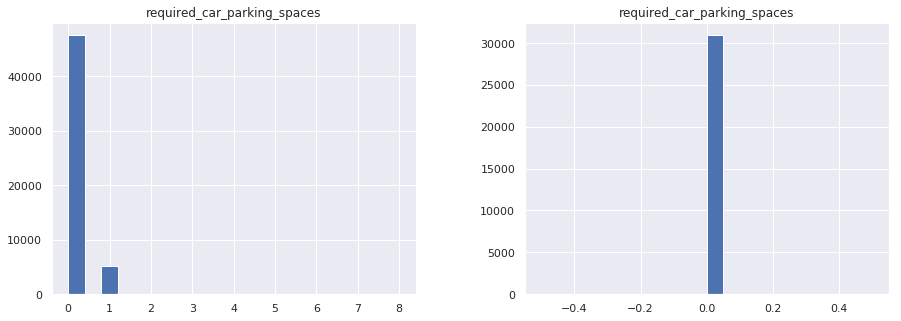

In [54]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train_0.hist(column='required_car_parking_spaces',bins=20,ax=axes[0])
train_1.hist(column='required_car_parking_spaces',bins=20,ax=axes[1])

In [0]:
train['required_car_parking_spaces'][train['required_car_parking_spaces'] >= 1] = 1
test['required_car_parking_spaces'][test['required_car_parking_spaces'] >= 1] = 1

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0d35071d0>],
      dtype=object)

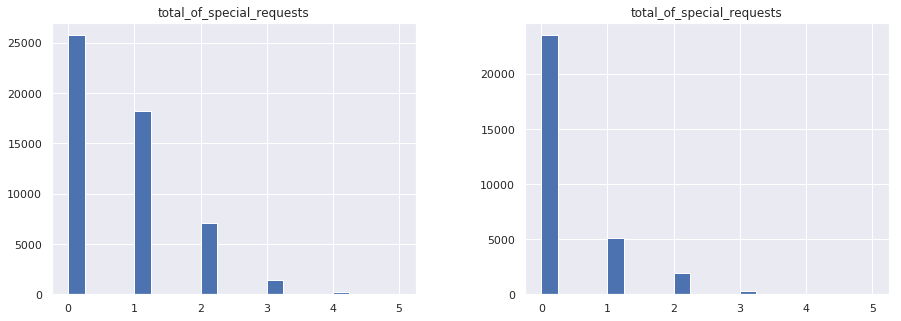

In [56]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train_0.hist(column='total_of_special_requests',bins=20,ax=axes[0])
train_1.hist(column='total_of_special_requests',bins=20,ax=axes[1])

In [0]:
train['total_of_special_requests'][train['total_of_special_requests'] >= 3] = 3
test['total_of_special_requests'][test['total_of_special_requests'] >= 3] = 3

In [0]:
train['total_days_q'], bins = pd.qcut(train['total_days'], q=4,labels=False, retbins=True)
train=train.drop('total_days',axis=1)
test['total_days_q']=pd.cut(test['total_days'], bins=bins,labels=False,precision=0)
test=test.drop('total_days',axis=1)

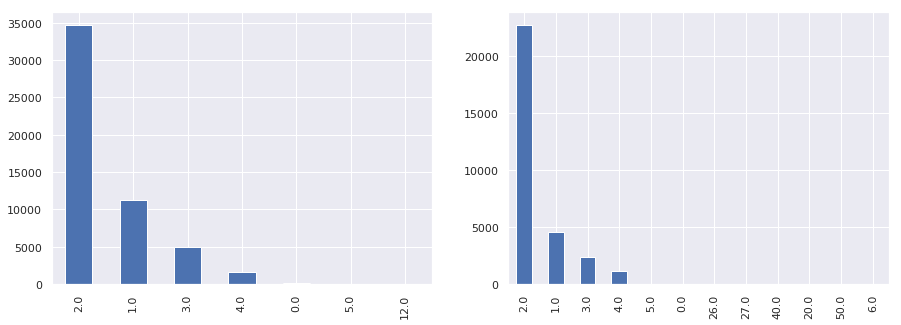

In [59]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train_0['total_customers'].value_counts().plot('bar',ax=axes[0])
train_1['total_customers'].value_counts().plot('bar',ax=axes[1])

In [0]:
train['total_customers'][train['total_customers'] >= 4] = 4
train['total_customers'][train['total_customers'] <= 0] = 1

test['total_customers'][test['total_customers'] >= 4] = 4
test['total_customers'][test['total_customers'] <= 1] = 1

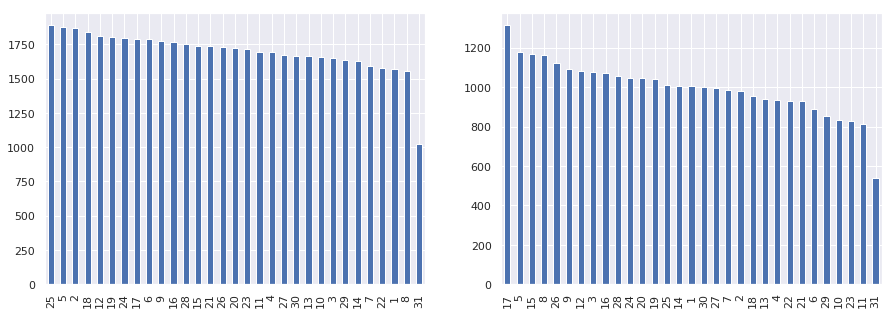

In [61]:
train_0=train[(train['is_canceled']==0)]
train_1=train[train['is_canceled']==1]
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train_0['arrival_date_day_of_month'].value_counts().plot('bar',ax=axes[0])
train_1['arrival_date_day_of_month'].value_counts().plot('bar',ax=axes[1])

In [0]:
train['arrival_date_day_of_month_q'], bins = pd.qcut(train['arrival_date_day_of_month'], q=4,labels=False, retbins=True)
train=train.drop('arrival_date_day_of_month',axis=1)
test['arrival_date_day_of_month_q']=pd.cut(test['arrival_date_day_of_month'], bins=bins,labels=False,precision=0)
test=test.drop('arrival_date_day_of_month',axis=1)

In [63]:
train.shape

(83573, 22)

In [64]:
train.columns

Index([u'hotel', u'is_canceled', u'arrival_date_year', u'arrival_date_month',
       u'meal', u'market_segment', u'distribution_channel',
       u'is_repeated_guest', u'reserved_room_type', u'assigned_room_type',
       u'booking_changes', u'deposit_type', u'customer_type',
       u'required_car_parking_spaces', u'total_of_special_requests',
       u'reservation_status', u'total_customers', u'lead_time_q',
       u'arrival_date_week_number_q', u'adr_q', u'total_days_q',
       u'arrival_date_day_of_month_q'],
      dtype='object')

### Model 1 

In [0]:
y_train = train["is_canceled"]
X_train = train.drop(["is_canceled"], axis=1)
y_test = test["is_canceled"]
X_test = test.drop(["is_canceled"], axis=1)

In [0]:
X_train_enc = pd.get_dummies(data=X_train,columns=X_train.columns)
X_test_enc = pd.get_dummies(data=X_test,columns=X_test.columns)
X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc=X_test_enc.fillna(0)

In [0]:
X_train_enc[:5]

,hotel_City Hotel,hotel_Resort Hotel,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,...,adr_q_2,adr_q_3,total_days_q_0,total_days_q_1,total_days_q_2,total_days_q_3,arrival_date_day_of_month_q_0,arrival_date_day_of_month_q_1,arrival_date_day_of_month_q_2,arrival_date_day_of_month_q_3
9710,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
40307,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
110051,1,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
22999,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
8344,0,1,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [68]:
clf_bern1 = BernoulliNB()
clf_bern1.fit(X_train_enc, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

<b> Parameters - </b>
1. Alpha - Smoothing parameter
2. Binarize - Threshold for binarizing (mapping to booleans) of sample features
3. Fit_prior - Learn class prior probabilities from data or using user provided priors
4. Class_prior - Prior probabilities of the classes. If specified the priors are not adjusted according to the data

## Evaluation metric
<b> Precission and Recall </b>


<img src="https://github.com/WomenWhoCode/WWCodeDataScience/blob/master/Intro_to_MachineLearning/img/PR%20diagram1.PNG?raw=1" width="200p"/>
<img src="https://github.com/WomenWhoCode/WWCodeDataScience/blob/master/Intro_to_MachineLearning/img/PR%20diagram%202.PNG?raw=1" width="400"/>


<br><b> Confusion Matrix </b>
<img src="https://github.com/WomenWhoCode/WWCodeDataScience/blob/master/Intro_to_MachineLearning/img/Confusion%20matrix.PNG?raw=1" width="200"/>

In [0]:
y_pred_bern1 = clf_bern1.predict(X_test_enc)
y_prob_bern1=clf_bern1.predict_proba(X_test_enc)

In [70]:
y_pred_bern1[:10]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [71]:
y_prob_bern1[:10]

array([[9.99999999e-01, 5.02418625e-10],
       [5.51943911e-11, 1.00000000e+00],
       [1.00000000e+00, 1.58222076e-10],
       [9.99999568e-01, 4.31729356e-07],
       [9.99989462e-01, 1.05375169e-05],
       [9.99998797e-01, 1.20295386e-06],
       [8.87965924e-10, 9.99999999e-01],
       [9.99999737e-01, 2.63231796e-07],
       [9.99999994e-01, 5.94617864e-09],
       [9.99994337e-01, 5.66287011e-06]])

In [72]:
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred_bern1)) 
print("recall score: ", recall_score(y_test,y_pred_bern1))
print("precision score: ", precision_score(y_test,y_pred_bern1))
print("f1 score: ", f1_score(y_test,y_pred_bern1))
print("accuracy score: ", accuracy_score(y_test,y_pred_bern1))

('test-set confusion matrix:\n', array([[22478,     0],
       [    0, 13339]]))
('recall score: ', 1.0)
('precision score: ', 1.0)
('f1 score: ', 1.0)
('accuracy score: ', 1.0)


### Model 2 - 
Remove the feature that is highly correlated with target feature
<br>
<b>Reservation_status</b> has high correlation with is_canceled. Looking at the values in column reveals that canceled is a reservation type. This might be causing data leak. Hence we will delete this feature

In [74]:
backup_train['reservation_status'].unique()

array(['Canceled', 'Check-Out', 'No-Show'], dtype=object)

In [0]:
X_train = X_train.drop('reservation_status',axis=1)
X_test = X_test.drop('reservation_status',axis=1)

In [0]:
X_train_enc = pd.get_dummies(data=X_train,columns=X_train.columns)
X_test_enc = pd.get_dummies(data=X_test,columns=X_test.columns)
X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc=X_test_enc.fillna(0)

In [77]:
clf_bern2 = BernoulliNB()
clf_bern2.fit(X_train_enc, y_train)
y_pred_bern2 = clf_bern2.predict(X_test_enc)
y_prob_bern2=clf_bern2.predict_proba(X_test_enc)
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred_bern2)) 
print("recall score: ", recall_score(y_test,y_pred_bern2))
print("precision score: ", precision_score(y_test,y_pred_bern2))
print("f1 score: ", f1_score(y_test,y_pred_bern2))
print("accuracy score: ", accuracy_score(y_test,y_pred_bern2))

('test-set confusion matrix:\n', array([[18713,  3765],
       [ 5549,  7790]]))
('recall score: ', 0.584001799235325)
('precision score: ', 0.674167027260926)
('f1 score: ', 0.6258536193460272)
('accuracy score: ', 0.7399558868693638)


### Model 3 - 
Let us remove 1 feature from the correlated feature pair
1. Arrival_date_year and arrival_date_month = -0.52
2. Reservation_status and deposit type = -0.46 
3. market_segment vs distribution_channel = 0.76
4. reserved_room_type vs assigned_room_type = 0.81

In [0]:
X_train = X_train.drop('arrival_date_month',axis=1)
X_test = X_test.drop('arrival_date_month',axis=1)

X_train = X_train.drop('market_segment',axis=1)
X_test = X_test.drop('market_segment',axis=1)

X_train = X_train.drop('reserved_room_type',axis=1)
X_test = X_test.drop('reserved_room_type',axis=1)

In [0]:
X_train_enc = pd.get_dummies(data=X_train,columns=X_train.columns)
X_test_enc = pd.get_dummies(data=X_test,columns=X_test.columns)
X_train_enc,X_test_enc =X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc=X_test_enc.fillna(0)

In [80]:
clf_bern3 = BernoulliNB()
clf_bern3.fit(X_train_enc, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [81]:
y_pred_bern3 = clf_bern3.predict(X_test_enc)
y_prob_bern3=clf_bern3.predict_proba(X_test_enc)
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred_bern3)) 
print("recall score: ", recall_score(y_test,y_pred_bern3))
print("precision score: ", precision_score(y_test,y_pred_bern3))
print("f1 score: ", f1_score(y_test,y_pred_bern3))
print("accuracy score: ", accuracy_score(y_test,y_pred_bern3))

('test-set confusion matrix:\n', array([[19029,  3449],
       [ 5595,  7744]]))
('recall score: ', 0.5805532648624334)
('precision score: ', 0.6918609845439114)
('f1 score: ', 0.6313386597097668)
('accuracy score: ', 0.7474942066616411)


In practice, even though Naive Bayes assumption of independent features is violated, there is no significant impact on model performance

## Implementing gaussian NB classifier

GaussianNB implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian. <a href="https://scikit-learn.org/stable/modules/naive_bayes.html">sklearn documentation</a>

In [0]:
train = backup_train.copy()
test=backup_test.copy()

In [0]:
train=train.fillna(0)
test=test.fillna(0)
y_train = train["is_canceled"]
X_train =train[['lead_time','arrival_date_week_number','days_in_waiting_list','adr','required_car_parking_spaces',\
               'total_days','total_of_special_requests','total_customers']]
y_test = test["is_canceled"]
X_test = test[['lead_time','arrival_date_week_number','days_in_waiting_list','adr','required_car_parking_spaces',\
               'total_days','total_of_special_requests','total_customers']]

In [84]:
classifier2 = GaussianNB()
classifier2.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

<b> Parameters - </b>
1. Priors - Prior probabilities of the classes. If specified the priors are not adjusted according to the data.
2. var_smoothing - Portion of the largest variance of all features that is added to variances for calculation stability.

In [0]:
y_pred2 = classifier2.predict(X_test)
y_prob2 = classifier2.predict_proba(X_test)

In [86]:
print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred2)) 
print("recall score: ", recall_score(y_test,y_pred2))
print("precision score: ", precision_score(y_test,y_pred2))
print("f1 score: ", f1_score(y_test,y_pred2))
print("accuracy score: ", accuracy_score(y_test,y_pred2))

('test-set confusion matrix:\n', array([[ 2756, 19722],
       [  131, 13208]]))
('recall score: ', 0.9901791738511133)
('precision score: ', 0.4010932280595202)
('f1 score: ', 0.5709222157383994)
('accuracy score: ', 0.4457101376441355)


## Implementing ensemble of Gaussian and Bernoulli NB
1. Gaussian NB is trained on continuous feature 
2. Bernoulli NB is trained on categorical features 
3. The product of probability of both models gives final probability 

In [101]:
backup_train[:5]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,meal,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,total_days,total_customers
9710,Resort Hotel,1,122,2016,December,53,27,BB,Online TA,TA/TO,0,D,D,3,No Deposit,0,Transient,74.75,0,2,Canceled,4,2.0
40307,City Hotel,1,20,2015,July,30,22,BB,Groups,TA/TO,0,A,A,0,No Deposit,0,Transient-Party,62.00,0,0,Canceled,2,2.0
110051,City Hotel,0,87,2017,April,16,16,BB,Online TA,TA/TO,0,D,D,0,No Deposit,0,Transient,171.00,0,0,Check-Out,5,3.0
22999,Resort Hotel,0,0,2017,February,5,2,BB,Online TA,TA/TO,1,A,A,0,No Deposit,0,Transient,43.00,0,1,Check-Out,1,1.0
8344,Resort Hotel,1,42,2016,September,39,23,BB,Online TA,TA/TO,0,A,A,0,No Deposit,0,Transient,109.00,0,1,Canceled,1,2.0


In [0]:
y_train = backup_train["is_canceled"]
X_train = backup_train.drop(["is_canceled"], axis=1)
y_test = backup_test["is_canceled"]
X_test = backup_test.drop(["is_canceled"], axis=1)

In [0]:
# Basic pre-processing
X_train['total_customers'][X_train['total_customers'] >= 4] = 4
X_train['total_customers'][X_train['total_customers'] <= 0] = 1
X_test['total_customers'][X_test['total_customers'] >= 4] = 4
X_test['total_customers'][X_test['total_customers'] <= 1] = 1


X_train['required_car_parking_spaces'][X_train['required_car_parking_spaces'] >= 1] = 1
X_test['required_car_parking_spaces'][X_test['required_car_parking_spaces'] >= 1] = 1



X_train['total_of_special_requests'][X_train['total_of_special_requests'] >= 3] = 3
X_test['total_of_special_requests'][X_test['total_of_special_requests'] >= 3] = 3

In [0]:
# one hot encoding the categorical features
cat_col=['hotel','arrival_date_year','arrival_date_month','meal','market_segment',\
          'distribution_channel','reserved_room_type','deposit_type','customer_type','is_repeated_guest',\
        'total_customers','required_car_parking_spaces','total_of_special_requests']
d_cat_train=pd.get_dummies(data=X_train[cat_col],columns=cat_col)
d_cat_test=pd.get_dummies(data=X_test[cat_col],columns=cat_col)

In [105]:
d_cat_test.shape

(35817, 63)

In [0]:
d_cat_train,d_cat_test =d_cat_train.align(d_cat_test, join='left', axis=1)
d_cat_test=d_cat_test.fillna(0)

In [107]:
clf_bern = BernoulliNB()
clf_bern.fit(d_cat_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [0]:
d_cont_train=X_train[['lead_time','arrival_date_week_number','days_in_waiting_list','adr','total_days']]
d_cont_train = d_cont_train.fillna(0)
d_cont_test = X_test[['lead_time','arrival_date_week_number','days_in_waiting_list','adr','total_days']]
d_cont_test=d_cont_test.fillna(0)

In [109]:
clf_gauss = GaussianNB()
clf_gauss.fit(d_cont_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
y_pred_bern=clf_bern.predict(d_cat_test)
y_pred_gauss=clf_gauss.predict(d_cont_test)

In [0]:
y_prob_bern=clf_bern.predict_proba(d_cat_test)
y_prob_bern_df = pd.DataFrame(data=y_prob_bern,columns=['prob0_b','prob1_b'])
y_prob_gauss=clf_gauss.predict_proba(d_cont_test)
y_prob_gauss_df = pd.DataFrame(data=y_prob_gauss,columns=['prob0_g','prob1_g'])

In [0]:
y_prob=y_prob_bern_df.join(y_prob_gauss_df)

In [0]:
y_prob['prob0']=y_prob['prob0_b']*y_prob['prob0_g']
y_prob['prob1']=y_prob['prob1_b']*y_prob['prob1_g']

In [127]:
y_prob[:10]

,prob0_b,prob1_b,prob0_g,prob1_g,prob0,prob1
0,0.986447,0.013553,0.633517,0.366483,0.624931,0.004967
1,0.254312,0.745688,0.804970,0.195030,0.204713,0.145432
2,0.965602,0.034398,0.856056,0.143944,0.826610,0.004951
3,0.801283,0.198717,0.853783,0.146217,0.684122,0.029056
4,0.206895,0.793105,0.813729,0.186271,0.168356,0.147733
5,0.316762,0.683238,0.679028,0.320972,0.215090,0.219301
6,0.801283,0.198717,0.853495,0.146505,0.683892,0.029113
7,0.618501,0.381499,0.795048,0.204952,0.491738,0.078189
8,0.781052,0.218948,0.827318,0.172682,0.646179,0.037808
9,0.266880,0.733120,0.578160,0.421840,0.154299,0.309260


In [0]:
y_prob['prediction']=np.where(y_prob['prob1'] > y_prob['prob0'], 1,0)

In [129]:
print("Bernoulli f1 score: ", f1_score(y_test,y_pred_bern))
print("Gaussian f1 score: ", f1_score(y_test,y_pred_gauss))
print("Ensemble f1 score: ", f1_score(y_test,y_prob['prediction']))

('Bernoulli f1 score: ', 0.6099612990072354)
('Gaussian f1 score: ', 0.36027222458528285)
('Ensemble f1 score: ', 0.5549425972864173)


## Comparing Gaussian NB and Bernuolli NB

In [0]:
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, y_prob_bern3[:,1])
roc_auc_bern = auc(false_positive_rate4, true_positive_rate4)

In [0]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob2[:,1])
roc_auc_gauss = auc(false_positive_rate, true_positive_rate)

Text(0.5,0,'False Positive Rate')

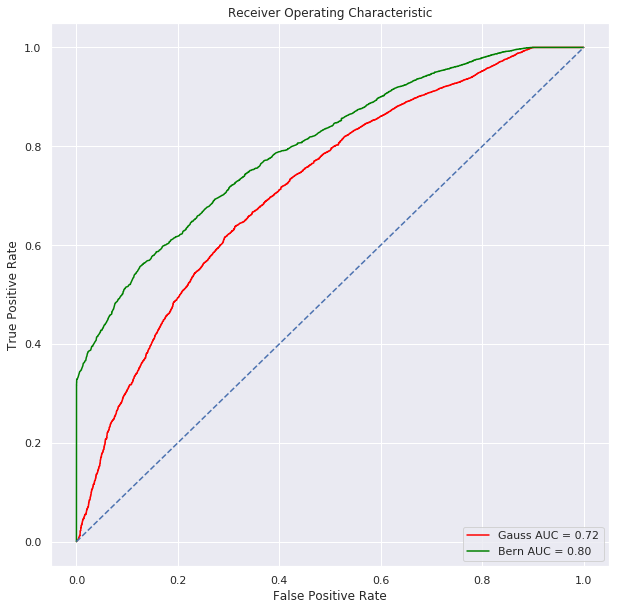

In [132]:
plt.figure(figsize = (10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'Gauss AUC = %0.2f' % roc_auc_gauss)
plt.plot(false_positive_rate4, true_positive_rate4, color = 'green', label = 'Bern AUC = %0.2f' % roc_auc_bern)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')